In [45]:
import cv2
import rasterio
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import math
import torch
from pathlib import Path
import albumentations as A
from segmentation_models_pytorch.utils import losses
import segmentation_models_pytorch as smp
from torch.utils.tensorboard import SummaryWriter
from rasterio.plot import reshape_as_image
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import PolynomialLR
from albumentations.pytorch import ToTensorV2
from torchvision import transforms

class SegmentDataset(Dataset):
    def __init__(self, 
                 image_path: Path, 
                 mask_path: Path, 
                 patch_size: int,
                 transform: A.Compose = None,
                 save_images = False,
                 path_to_save = None):
        super().__init__()
        self.image_path = image_path
        self.mask_path = mask_path
        self.patch_size = patch_size
        self.transform = transform
        self.save_images = save_images
        self.path_to_save = path_to_save
 
        with rasterio.open(self.image_path, 'r', driver='JP2OpenJPEG') as src:
                self.image_raster = src.read()

        with rasterio.open(self.mask_path, 'r', driver='JP2OpenJPEG') as src:
                self.mask_raster = src.read()

        if self.image_raster[0].shape == self.mask_raster[0].shape:
            self.width = self.image_raster.shape[1]
            self.height = self.image_raster.shape[2]

            self.images = self.make_patches(self.image_raster)
            self.masks = self.make_patches(self.mask_raster)
        
        if self.save_images:
            self.save_patches()
            
    def make_patches(self, raster: np.array): 
        slices = []    
        for h_cord in np.arange(start=self.patch_size, 
                                stop=self.height + 1, 
                                step=self.patch_size):
            for w_cord in np.arange(start=self.patch_size, 
                                    stop=self.width + 1, 
                                    step=self.patch_size):
                slices.append(reshape_as_image(raster[:, 
                                     h_cord - self.patch_size: h_cord, 
                                     w_cord - self.patch_size: w_cord]))
        return slices
    
    # TODO
    # If images found load from cashe
    def save_patches(self):
        if self.patch_size is None:
            raise ValueError('You must specify patch size.')
        tqd = tqdm(enumerate(zip(self.images, self.masks), start = 1))
        
        for i, (image, mask) in tqd:
            parent = Path(self.path_to_save) / str(self.patch_size)
            img_path = parent / 'images'
            mask_path = parent / 'masks'
            
            img_path.mkdir(exist_ok=True, parents=True)
            mask_path.mkdir(exist_ok=True, parents=True)
            
            cv2.imwrite(str(img_path / f'{i}.jpg'), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
            cv2.imwrite(str(mask_path / f'{i}.jpg'), mask)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
        return image, mask

In [82]:
args = {
    'image_path': 'data/raw/image.jp2',
    'mask_path': 'data/raw/mask.jp2',
    'patch_size': 256,
    'path_to_save': 'data',
    'save_images': False,
    'mean_std_path': 'data/cashe/mean_std.pth',
    'test_ratio' : 0.2,
    'device': 'cuda',
    'batch_size': 16,
    'num_workers': 1,
    'lr': 1e-2,
    'momentum': 0.9,
    'weight_decay': 1e-3,
    'epochs': 50,
    'encoder_name': 'efficientnet-b0',
    'encoder_weights': 'imagenet'
}

In [77]:
def get_mean_std(args):
    p = Path(args['mean_std_path'])
    if p.exists():
        file = torch.load(p)
        print('Mean and std loaded from cashe.')
        return file['mean'], file['std']

    ds = SegmentDataset(image_path = args['image_path'], 
                        mask_path = args['mask_path'], 
                        patch_size = args['patch_size'],
                        transform = ToTensorV2())

    dl = DataLoader(ds, batch_size=len(ds), shuffle=False, num_workers=0)

    images, _ = next(iter(dl))
    images = images / 255
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0, 2, 3]), images.std([0, 2, 3])
    return mean, std

def get_transform(train, args):
    trans = []
    if train:
        trans.extend([
            
        ])
        
    trans.extend([
        A.Normalize(*get_mean_std(args)),
        ToTensorV2()
    ])
    trans = A.Compose(trans)
    return trans

def get_samplers(train_len, args):
    indices = torch.randperm(train_len)

    # Count limit number for train and val ids
    split = int(math.ceil(args['test_ratio'] * train_len))
    train_idx, test_idx = indices[split:], indices[:split]

    # Create sampler for given ids
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
    
    return train_sampler, test_sampler

In [34]:
def get_datasets(args):
    train_dataset = SegmentDataset(image_path = args['image_path'], 
                         mask_path = args['mask_path'], 
                         patch_size = args['patch_size'],
                         transform = get_transform(True, args),
                         path_to_save = args['path_to_save'], 
                         save_images = args['save_images'])
    
    test_dataset = SegmentDataset(image_path = args['image_path'], 
                         mask_path = args['mask_path'], 
                         patch_size = args['patch_size'],
                         transform = get_transform(False, args),
                         path_to_save = args['path_to_save'], 
                         save_images = args['save_images'])
    
    return train_dataset, test_dataset

In [35]:
class MetricWriter(SummaryWriter):
    # Making singleton out of summary writer
    _instances = {}
    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            instance = super().__call__(*args, **kwargs)
            cls._instances[cls] = instance
        return cls._instances[cls]

In [37]:
def train_epoch(model, loss_fn, optimizer, train_loader, lr_scheduler, epoch, device):
    model.train()
    train_loss = 0.0
    writer = MetricWriter()
    for images, targets in tqdm(train_loader):
        images, targets = images.to(device), targets.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    lr_scheduler.step()
    train_loss /= len(train_loader)
    writer.add_scalar('Train/loss', train_loss, epoch)
    return train_loss

In [39]:
def test_epoch(model, loss_fn, test_loader, metrics, epoch, device):
    model.eval()
    metrics_sum = {}
    test_loss = 0.0
    writer = MetricWriter()
    with torch.inference_mode():
        for images, targets in tqdm(test_loader):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = loss_func(outputs, targets)
            test_loss += loss.item()
            
            tp, fp, fn, tn = smp.metrics.get_stats(outputs, targets, mode='binary', threshold=0.5, num_classes = 2)
            for name, fn in metrics.items():
                metrics_sum[name].setdefault(0.0)
                metrics_sum[name] += fn(tp, fp, fn, tn)
                
    test_loss /= len(test_loader)     
    metrics_mean = {key: value / len(test_loader) for key, value in metrics_sum.items()}  
    writer.add_scalar('Test', metrics_mean, epoch)
    writer.add_scalar('Test/loss', test_loss, epoch)
    return test_loss, metrics_mean

In [84]:
def main(args):
    device = torch.device(args['device'])
#   train_dataset, test_dataset = get_datasets(args)
    
    train_len = len(train_dataset)
    train_sampler, test_sampler = get_samplers(train_len, args)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=args['batch_size'],
        shuffle = False,
        sampler = train_sampler,
        num_workers = args['num_workers']
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=args['batch_size'],
        shuffle = False,
        sampler = test_sampler,
        num_workers = args['num_workers']
    )
    
    model = smp.Unet(
        encoder_name = args['encoder_name'],
        encoder_weights = args['encoder_weights']
    )
    
    params_to_optimize = [
        {'params': [p for p in model.decoder.parameters() if p.requires_grad]},
        {'params': [p for p in model.encoder.parameters() if p.requires_grad]}
    ]
    # TODO
    # Move to function
    # Add parameters to optimizer if performance sucks
    # Same with lr scheduler
    optimizer = torch.optim.SGD(params_to_optimize, lr = args['lr'])
    
    # TODO
    # Move to function
    # Same with lr scheduler
    lr_scheduler = PolynomialLR(
        optimizer, power=0.9
    )
    
    #TODO
    # Move to function
    loss_fn = losses.BCEWithLogitsLoss()
    
    # TODO
    # Move to function
    metrics = {
    'iou': smp.metrics.iou_score,
    'precision': smp.metrics.precision,
    'recall': smp.metrics.recall,
    'accuracy': smp.metrics.accuracy,
    'f1': smp.metrics.f1_score
    }

    # TODO
    # Add resuming
    
    for epoch in range(1, args['epochs']):
        train_loss = train_epoch(
            model,
            loss_fn,
            optimizer,
            train_loader, 
            lr_scheduler, 
            epoch, 
            device
        )
        
        test_loss, eval_metrics = test_epoch(
            model,
            loss_fn,
            test_loader,
            metrics, 
            epoch,
            device)
        
        header = f'EPOCH {epoch}|'
        train_loss_summary = f'TRAIN LOSS: {train_loss:.3f}|'
        test_loss_summary = f'TEST LOSS: {test_loss:.3f}|'
        eval_summary = ''.join(f'TEST_{key.upper()}: {value:.3f}|'.format(key) for key, value in eval_metrics.items())
        print(header, train_loss_summary, test_loss_summary, eval_summary)

In [75]:
train_dataset, test_dataset = get_datasets(args)

In [ ]:
main(args)

In [6]:
ds = get_datasets(args)

In [7]:
it = iter(ds[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


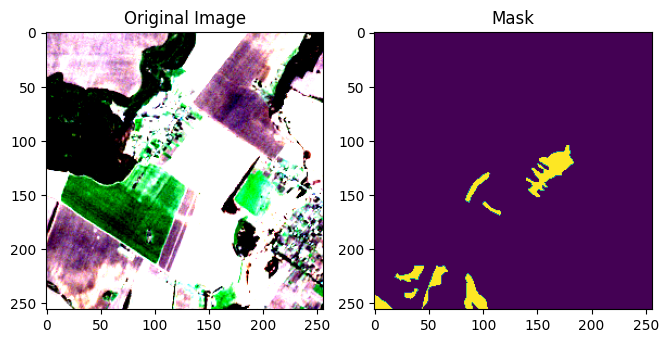

In [8]:
import matplotlib.pyplot as plt
# create a new figure
fig = plt.figure(figsize=(10, 5))
org, mask = next(it)

# add the original image subplot to the figure
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(org.permute(1, 2, 0))
ax1.set_title('Original Image')

# add the mask subplot to the figure
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(mask)
ax2.set_title('Mask')

# adjust the spacing between subplots
fig.tight_layout()

# show the figure
plt.show()